<a href="https://colab.research.google.com/github/sanaretty/Nutrition_/blob/main/nutrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ConvNeXtBase, ConvNeXtXLarge
from tensorflow.keras.layers import GlobalAveragePooling2D

In [18]:
import tensorflow as tf
from tensorflow.python.client import device_lib

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
    device_info = device_lib.list_local_devices()
    for device in device_info:
        if device.device_type == 'GPU':
            print(f"Device name: {device.name}, device type: {device.device_type}, description: {device.physical_device_desc}")
else:
    print("GPU is not available")


GPU is not available


In [19]:
import gdown
import zipfile
import os

In [20]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
file_id = '1sTNJaQ0VUsXJvk2DAkcA2zmyuQBAjpmo'
output_file = '/content/drive/My Drive/Food-101.zip'
extract_dir = '/content/Food-101'

if not os.path.exists(output_file):
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(output_file, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

print(os.listdir(extract_dir))

['Food-101']


In [22]:
print("Contents of extract directory:")
print(os.listdir(extract_dir))

Contents of extract directory:
['Food-101']


In [23]:
data_dir = os.path.join(extract_dir, 'Food-101')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [24]:
print("Train directory:", train_dir)
print("Test directory:", test_dir)
print("Contents of train directory:", os.listdir(train_dir)[:10])
print("Contents of test directory:", os.listdir(test_dir)[:10])

Train directory: /content/Food-101/Food-101/train
Test directory: /content/Food-101/Food-101/test
Contents of train directory: ['fried_calamari', 'caprese_salad', 'fried_rice', 'foie_gras', 'breakfast_burrito', 'hot_dog', 'greek_salad', 'oysters', 'garlic_bread', 'spaghetti_bolognese']
Contents of test directory: ['fried_calamari', 'caprese_salad', 'fried_rice', 'foie_gras', 'breakfast_burrito', 'hot_dog', 'greek_salad', 'oysters', 'garlic_bread', 'spaghetti_bolognese']


In [25]:
subdirectories = [os.path.join(train_dir, d) for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
subdirectories

['/content/Food-101/Food-101/train/fried_calamari',
 '/content/Food-101/Food-101/train/caprese_salad',
 '/content/Food-101/Food-101/train/fried_rice',
 '/content/Food-101/Food-101/train/foie_gras',
 '/content/Food-101/Food-101/train/breakfast_burrito',
 '/content/Food-101/Food-101/train/hot_dog',
 '/content/Food-101/Food-101/train/greek_salad',
 '/content/Food-101/Food-101/train/oysters',
 '/content/Food-101/Food-101/train/garlic_bread',
 '/content/Food-101/Food-101/train/spaghetti_bolognese',
 '/content/Food-101/Food-101/train/tacos',
 '/content/Food-101/Food-101/train/eggs_benedict',
 '/content/Food-101/Food-101/train/dumplings',
 '/content/Food-101/Food-101/train/gyoza',
 '/content/Food-101/Food-101/train/carrot_cake',
 '/content/Food-101/Food-101/train/tuna_tartare',
 '/content/Food-101/Food-101/train/chicken_quesadilla',
 '/content/Food-101/Food-101/train/pork_chop',
 '/content/Food-101/Food-101/train/guacamole',
 '/content/Food-101/Food-101/train/beet_salad',
 '/content/Food-101/

In [26]:
import PIL
from PIL import Image
import os

In [27]:
# Identify and delete corrupted image in each of the folder file
for folder_path in subdirectories:
  for filename in os.listdir(folder_path):
      try:
          image = Image.open(os.path.join(folder_path, filename))
      except PIL.UnidentifiedImageError as e:
          print(f"Error in file {filename}: {e}")
          os.remove(os.path.join(folder_path, filename))
          print(f"Removed file {filename}")

In [28]:
import os
from PIL import Image

base_dir = '/content/Food-101/Food-101'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')


# Combine train and test directories for processing
directories = [train_dir, test_dir]

# List subdirectories (class folders) in train and test directories
for main_dir in directories:
    subdirectories = [os.path.join(main_dir, d) for d in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, d))]

    print(f"Processing directory: {main_dir}")

    # Identify and delete corrupted images in each folder
    for folder_path in subdirectories:
        print(f"Processing subdirectory: {folder_path}")

        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)

            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify that the file is a valid image
            except (IOError, SyntaxError, PIL.UnidentifiedImageError) as e:
                print(f"Error in file {file_path}: {e}")
                os.remove(file_path)
                print(f"Removed file {file_path}")

print("Completed checking and removing corrupted images.")


Processing directory: /content/Food-101/Food-101/train
Processing subdirectory: /content/Food-101/Food-101/train/fried_calamari
Processing subdirectory: /content/Food-101/Food-101/train/caprese_salad
Processing subdirectory: /content/Food-101/Food-101/train/fried_rice
Processing subdirectory: /content/Food-101/Food-101/train/foie_gras
Processing subdirectory: /content/Food-101/Food-101/train/breakfast_burrito
Processing subdirectory: /content/Food-101/Food-101/train/hot_dog
Processing subdirectory: /content/Food-101/Food-101/train/greek_salad
Processing subdirectory: /content/Food-101/Food-101/train/oysters
Processing subdirectory: /content/Food-101/Food-101/train/garlic_bread
Processing subdirectory: /content/Food-101/Food-101/train/spaghetti_bolognese
Processing subdirectory: /content/Food-101/Food-101/train/tacos
Processing subdirectory: /content/Food-101/Food-101/train/eggs_benedict
Processing subdirectory: /content/Food-101/Food-101/train/dumplings
Processing subdirectory: /conten

In [29]:
low_count_categories = [
    'hot_dog',
    'pizza',
    'omelette',
    'caesar_salad',
    'falafel',
    'chicken_curry',
    'ice_cream',
    'chocolate_cake',
    'lasagna',
    'sushi',
    'steak',
    'baklava',
    'cheesecake'
]

In [30]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for category in low_count_categories:
    category_dir = os.path.join(train_dir, category)
    images = os.listdir(category_dir)
    num_images = len(images)
    if num_images < 1100:
        print(f"Augmenting data for category: {category}")
        for image_name in images:
            img_path = os.path.join(category_dir, image_name)
            img = load_img(img_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=category_dir, save_prefix='aug', save_format='jpg'):
                i += 1
                if i >= 2:
                    break

In [31]:
categories = sorted(os.listdir(train_dir))
categories

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [32]:
df = pd.DataFrame(columns=['image_path', 'label'])
df

,image_path,label


In [33]:
dfs = []

for category in categories:
    category_path = os.path.join(train_dir, category)
    image_data = []
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_data.append({'image_path': image_path, 'label': category})
    df_category = pd.DataFrame(image_data)
    dfs.append(df_category)

In [34]:
df = pd.concat(dfs, ignore_index=True)
df

,image_path,label
0,/content/Food-101/Food-101/train/apple_pie/437...,apple_pie
1,/content/Food-101/Food-101/train/apple_pie/366...,apple_pie
2,/content/Food-101/Food-101/train/apple_pie/183...,apple_pie
3,/content/Food-101/Food-101/train/apple_pie/311...,apple_pie
4,/content/Food-101/Food-101/train/apple_pie/284...,apple_pie
...,...,...
93889,/content/Food-101/Food-101/train/waffles/29078...,waffles
93890,/content/Food-101/Food-101/train/waffles/28333...,waffles
93891,/content/Food-101/Food-101/train/waffles/19649...,waffles
93892,/content/Food-101/Food-101/train/waffles/15209...,waffles


In [35]:
df['label'].value_counts()

,count
label,
hot_dog,2163
baklava,2155
chocolate_cake,2155
steak,2151
chicken_curry,2150
...,...
eggs_benedict,750
edamame,750
dumplings,750


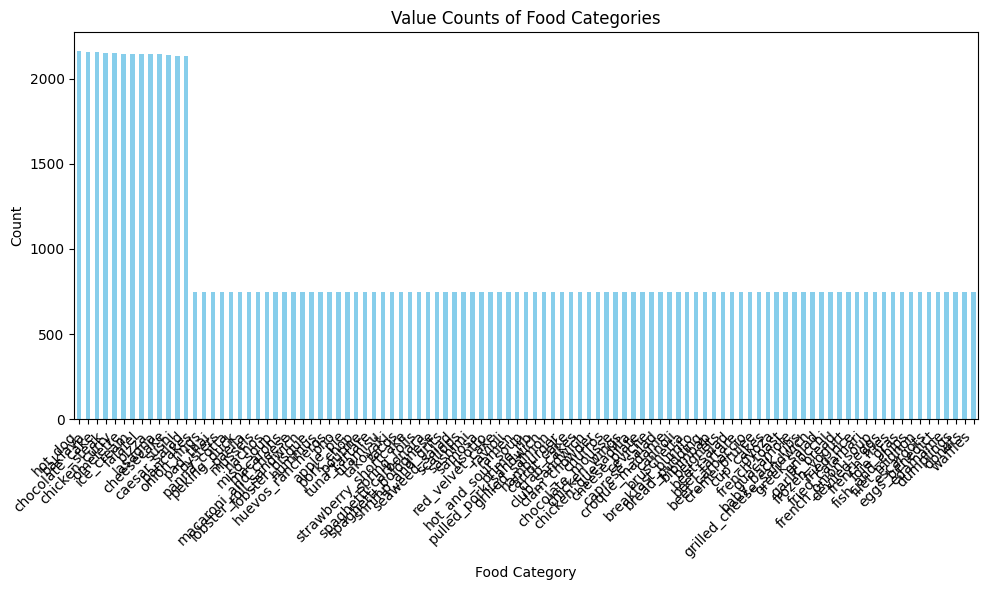

In [36]:
plt.figure(figsize=(10, 6))

df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Food Category')
plt.ylabel('Count')
plt.title('Value Counts of Food Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [37]:
df['label'].value_counts()

,count
label,
hot_dog,2163
baklava,2155
chocolate_cake,2155
steak,2151
chicken_curry,2150
...,...
eggs_benedict,750
edamame,750
dumplings,750


In [38]:
labels = df['label']

In [39]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

In [40]:
class_weights_dict = dict(enumerate(class_weights))

In [41]:
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.2395247524752475, 1: 1.2395247524752475, 2: 0.43138912499138543, 3: 1.2395247524752475, 4: 1.2395247524752475, 5: 1.2395247524752475, 6: 1.2395247524752475, 7: 1.2395247524752475, 8: 1.2395247524752475, 9: 1.2395247524752475, 10: 1.2395247524752475, 11: 0.4364523776321294, 12: 1.2395247524752475, 13: 1.2395247524752475, 14: 1.2395247524752475, 15: 1.2395247524752475, 16: 1.2395247524752475, 17: 0.43522638780732004, 18: 0.43239235551462124, 19: 1.2395247524752475, 20: 1.2395247524752475, 21: 0.43138912499138543, 22: 1.2395247524752475, 23: 1.2395247524752475, 24: 1.2395247524752475, 25: 1.2395247524752475, 26: 1.2395247524752475, 27: 1.2395247524752475, 28: 1.2395247524752475, 29: 1.2395247524752475, 30: 1.2395247524752475, 31: 1.2395247524752475, 32: 1.2395247524752475, 33: 1.2395247524752475, 34: 1.2395247524752475, 35: 1.2395247524752475, 36: 0.4336024087483375, 37: 1.2395247524752475, 38: 1.2395247524752475, 39: 1.2395247524752475, 40: 1.2395247524752475, 41: 1.

In [42]:
class_weights

array([1.23952475, 1.23952475, 0.43138912, 1.23952475, 1.23952475,
       1.23952475, 1.23952475, 1.23952475, 1.23952475, 1.23952475,
       1.23952475, 0.43645238, 1.23952475, 1.23952475, 1.23952475,
       1.23952475, 1.23952475, 0.43522639, 0.43239236, 1.23952475,
       1.23952475, 0.43138912, 1.23952475, 1.23952475, 1.23952475,
       1.23952475, 1.23952475, 1.23952475, 1.23952475, 1.23952475,
       1.23952475, 1.23952475, 1.23952475, 1.23952475, 1.23952475,
       1.23952475, 0.43360241, 1.23952475, 1.23952475, 1.23952475,
       1.23952475, 1.23952475, 1.23952475, 1.23952475, 1.23952475,
       1.23952475, 1.23952475, 1.23952475, 1.23952475, 1.23952475,
       1.23952475, 1.23952475, 1.23952475, 1.23952475, 1.23952475,
       0.4297936 , 1.23952475, 1.23952475, 0.43360241, 0.43380474,
       1.23952475, 1.23952475, 1.23952475, 1.23952475, 1.23952475,
       1.23952475, 1.23952475, 0.43319831, 1.23952475, 1.23952475,
       1.23952475, 1.23952475, 1.23952475, 1.23952475, 1.23952

In [43]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [44]:
train_df.shape

(75115, 2)

In [45]:
val_df.shape

(18779, 2)

In [46]:
augmentation_params = {
    'rotation_range': 20,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.2,
    'zoom_range': 0.1,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}

In [47]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    **augmentation_params
)

In [48]:
img_size = (224, 224)

In [49]:
batch_size = 32

In [50]:
val_datagen = ImageDataGenerator(
    rescale = 1./255
    )

In [51]:
train_images = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',

    target_size=img_size,
    batch_size=batch_size,

    shuffle=True,
    seed=42,
    class_mode='categorical'
)

Found 75115 validated image filenames belonging to 101 classes.


In [52]:
val_images = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',

    target_size=img_size,
    batch_size=batch_size,

    shuffle=False,
    seed=42,
    class_mode='categorical'
)

Found 18779 validated image filenames belonging to 101 classes.


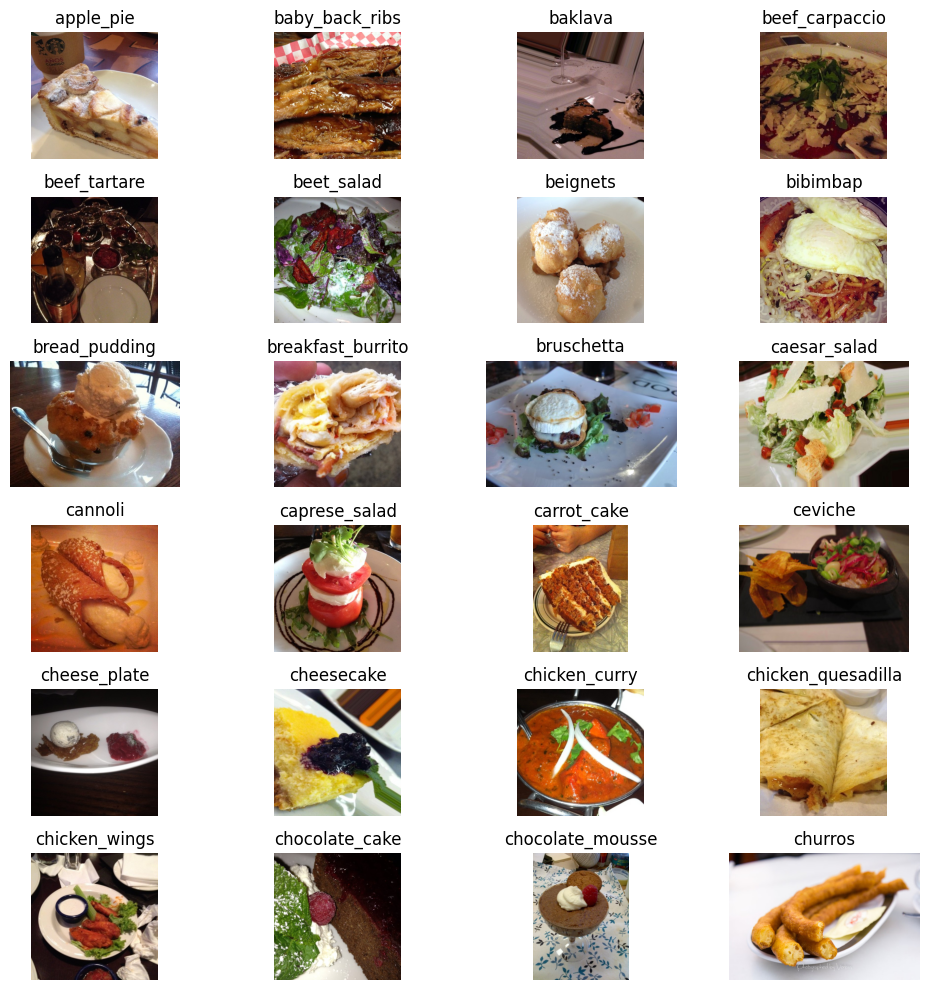

In [53]:
fig, axes = plt.subplots(6, 4, figsize=(10, 10))
axes = axes.flatten()

for i, category in enumerate(categories[:24]): # Limit categories to the number of axes
    category_df = train_df[train_df['label'] == category]
    # Check if the category has at least 101 images
    if len(category_df) > 100:
        image_path = category_df.iloc[100]['image_path']
        img = plt.imread(image_path)
        axes[i].imshow(img)
        axes[i].set_title(category)
        axes[i].axis('off')
    else:
        print(f"Category {category} does not have enough images.")

plt.tight_layout()
plt.show()

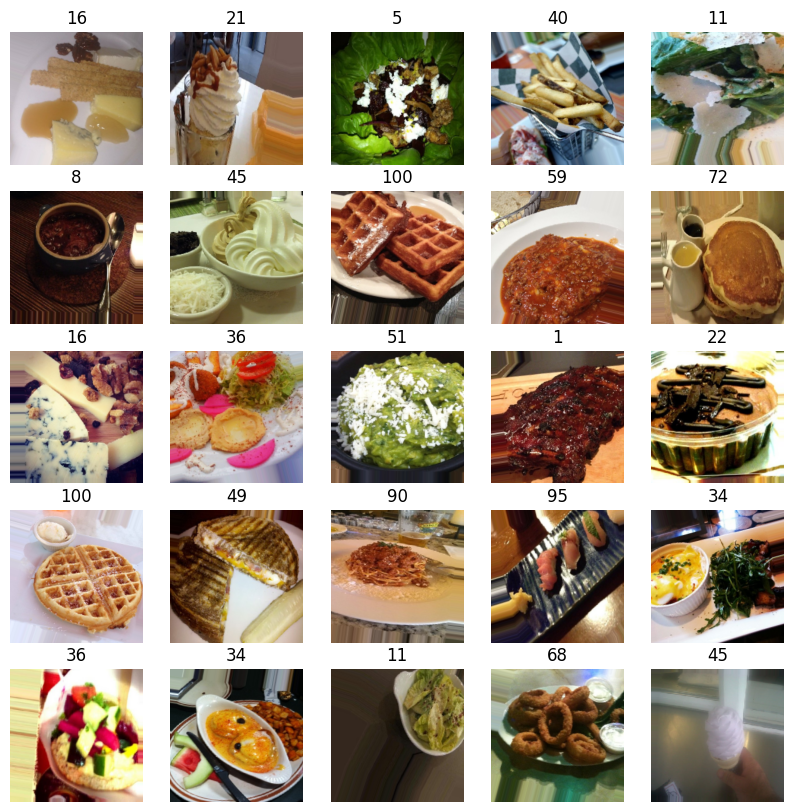

In [54]:
batch_train_images, batch_train_labels = next(train_images)

class_names = np.argmax(batch_train_labels, axis=1)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(batch_train_images[i])
    plt.title(class_names[i])
    plt.axis('off')
plt.show()

In [55]:
pretrained_model = MobileNetV2(
    input_shape=(img_size[0], img_size[1], 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

# x = Dense(8, activation='relu')(pretrained_model.output)
# x = Dense(16, activation='relu')(x)
outputs = Dense(len(categories), activation='softmax')(pretrained_model.output)

model_mn = Model(pretrained_model.input, outputs, name='MobileNetV2')

# print(model_mn.summary())

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [56]:
model_mn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [57]:
history_mn = model_mn.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2348/2348 ━━━━━━━━━━━━━━━━━━━━ 4876s 2s/step - accuracy: 0.3599 - loss: 2.7084 - val_accuracy: 0.5051 - val_loss: 1.9680
Epoch 2/5
2348/2348 ━━━━━━━━━━━━━━━━━━━━ 4841s 2s/step - accuracy: 0.5351 - loss: 1.8296 - val_accuracy: 0.5235 - val_loss: 1.9242
Epoch 3/5
2348/2348 ━━━━━━━━━━━━━━━━━━━━ 4947s 2s/step - accuracy: 0.5634 - loss: 1.6990 - val_accuracy: 0.5257 - val_loss: 1.9179
Epoch 4/5
2348/2348 ━━━━━━━━━━━━━━━━━━━━ 4747s 2s/step - accuracy: 0.5828 - loss: 1.6122 - val_accuracy: 0.5210 - val_loss: 1.9568


In [58]:
model_mn.save('/content/models/MobileNet_V2.h5', save_format='h5')

In [63]:
 model_mn.save('my_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


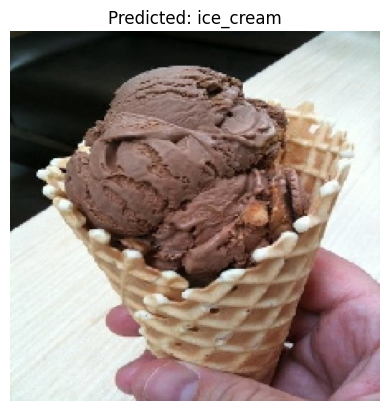

The model predicts this image is: ice_cream


In [69]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model (replace 'your_model.h5' with your model's filename)
model = tf.keras.models.load_model('/content/models/MobileNet_V2.h5')

# Path to the test image (replace with your actual image path)
img_path = '/content/Food-101/Food-101/test/ice_cream/142995.jpg'  # Replace with your test image path

# Load the image and preprocess it
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model's input size
img_array = image.img_to_array(img)  # Convert to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Normalize the image (if your model was trained on normalized images)
img_array /= 255.0

# Predict the class of the image
predictions = model.predict(img_array)

# Decode the predictions
predicted_class = np.argmax(predictions[0])

# Load class labels (replace with your actual labels)
class_labels = ['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster_roll_sandwich',
 'macaroni_and_cheese',
 'macarons',
 'miso_soup',
 'mussels',
 'nachos',
 'omelette',
 'onion_rings',
 'oysters',
 'pad_thai',
 'paella',
 'pancakes',
 'panna_cotta',
 'peking_duck',
 'pho',
 'pizza',
 'pork_chop',
 'poutine',
 'prime_rib',
 'pulled_pork_sandwich',
 'ramen',
 'ravioli',
 'red_velvet_cake',
 'risotto',
 'samosa',
 'sashimi',
 'scallops',
 'seaweed_salad',
 'shrimp_and_grits',
 'spaghetti_bolognese',
 'spaghetti_carbonara',
 'spring_rolls',
 'steak',
 'strawberry_shortcake',
 'sushi',
 'tacos',
 'takoyaki',
 'tiramisu',
 'tuna_tartare',
 'waffles']  # Example labels, replace with yours

# Get the label of the predicted class
predicted_label = class_labels[predicted_class]

# Display the image and prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_label}')
plt.axis('off')
plt.show()

print(f'The model predicts this image is: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


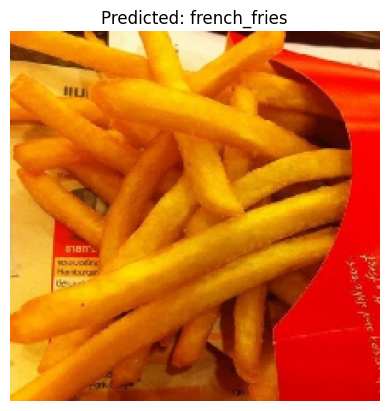

The model predicts this image is: french_fries


In [70]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model (replace 'your_model.h5' with your model's filename)
model = tf.keras.models.load_model('/content/models/MobileNet_V2.h5')

# Path to the test image (replace with your actual image path)
img_path = '/content/Food-101/Food-101/test/french_fries/531883.jpg'  # Replace with your test image path

# Load the image and preprocess it
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model's input size
img_array = image.img_to_array(img)  # Convert to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Normalize the image (if your model was trained on normalized images)
img_array /= 255.0

# Predict the class of the image
predictions = model.predict(img_array)

# Decode the predictions
predicted_class = np.argmax(predictions[0])

# Load class labels (replace with your actual labels)
class_labels = ['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster_roll_sandwich',
 'macaroni_and_cheese',
 'macarons',
 'miso_soup',
 'mussels',
 'nachos',
 'omelette',
 'onion_rings',
 'oysters',
 'pad_thai',
 'paella',
 'pancakes',
 'panna_cotta',
 'peking_duck',
 'pho',
 'pizza',
 'pork_chop',
 'poutine',
 'prime_rib',
 'pulled_pork_sandwich',
 'ramen',
 'ravioli',
 'red_velvet_cake',
 'risotto',
 'samosa',
 'sashimi',
 'scallops',
 'seaweed_salad',
 'shrimp_and_grits',
 'spaghetti_bolognese',
 'spaghetti_carbonara',
 'spring_rolls',
 'steak',
 'strawberry_shortcake',
 'sushi',
 'tacos',
 'takoyaki',
 'tiramisu',
 'tuna_tartare',
 'waffles']  # Example labels, replace with yours

# Get the label of the predicted class
predicted_label = class_labels[predicted_class]

# Display the image and prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_label}')
plt.axis('off')
plt.show()

print(f'The model predicts this image is: {predicted_label}')

In [71]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
!cp /content/models/MobileNet_V2.h5 /content/drive/My\ Drive/


In [73]:
!cp /content/my_model.keras /content/drive/My\ Drive/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


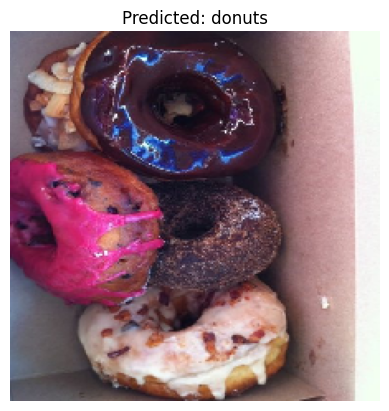

The model predicts this image is: donuts


In [74]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('/content/models/MobileNet_V2.h5')
img_path = '/content/Food-101/Food-101/test/donuts/211626.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

class_labels = ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad',
                'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad',
                'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake',
                'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse',
                'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame',
                'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots',
                'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup',
                'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi',
                'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger',
                'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna',
                'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup',
                'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters', 'pad_thai', 'paella', 'pancakes',
                'panna_cotta', 'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib',
                'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi',
                'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese', 'spaghetti_carbonara',
                'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu',
                'tuna_tartare', 'waffles']

predicted_label = class_labels[predicted_class]

plt.imshow(img)
plt.title(f'Predicted: {predicted_label}')
plt.axis('off')
plt.show()

print(f'The model predicts this image is: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


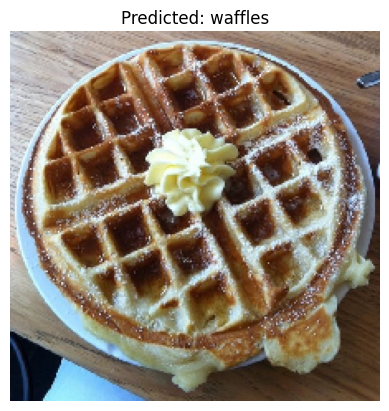

The model predicts this image is: waffles


In [76]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('/content/models/MobileNet_V2.h5')
img_path = '/content/Food-101/Food-101/test/waffles/502002.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

class_labels = ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad',
                'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad',
                'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake',
                'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse',
                'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame',
                'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots',
                'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup',
                'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi',
                'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger',
                'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna',
                'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup',
                'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters', 'pad_thai', 'paella', 'pancakes',
                'panna_cotta', 'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib',
                'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi',
                'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese', 'spaghetti_carbonara',
                'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu',
                'tuna_tartare', 'waffles']

predicted_label = class_labels[predicted_class]

plt.imshow(img)
plt.title(f'Predicted: {predicted_label}')
plt.axis('off')
plt.show()

print(f'The model predicts this image is: {predicted_label}')
